# MLDA for the Basin using `gpuocean.dataassimilation.MLEnKF`

### Classes and modules

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [3]:
from gpuocean.utils import IPythonMagic, Common, WindStress
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [4]:
%cuda_context_handler gpu_ctx

In [5]:
gpu_stream = cuda.Stream()

Basin utils

In [6]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinPlot import * 

## Data Assimilation

In [8]:
L = 10

In [9]:
lvl_grid_args = initGridSpecs(L)
args = {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } 

In [10]:
from utils.BasinParameters import * 

In [11]:
data_args = make_init_steady_state(args, a=steady_state_bump_a, bump_fractal_dist=steady_state_bump_fractal_dist) 

### Truth

In [12]:
from gpuocean.SWEsimulators import ModelErrorKL
true_init_mekl = ModelErrorKL.ModelErrorKL(**args, **init_model_error_basis_args)
true_sim_mekl = ModelErrorKL.ModelErrorKL(**args, **sim_model_error_basis_args)

truth = make_sim(args, sample_args=sample_args, init_fields=data_args)
true_init_mekl.perturbSim(truth)
truth.model_error = true_sim_mekl
truth.model_time_step = sim_model_error_timestep

In [13]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)

In [15]:
from utils.BasinSL import *
obs_x, obs_y = obs_xs[0], obs_ys[0]
Hx, Hy = SLobsCoord2obsIdx([truth],obs_x, obs_y)

In [16]:
obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

Text(0.5, 0.85, 'Truth')

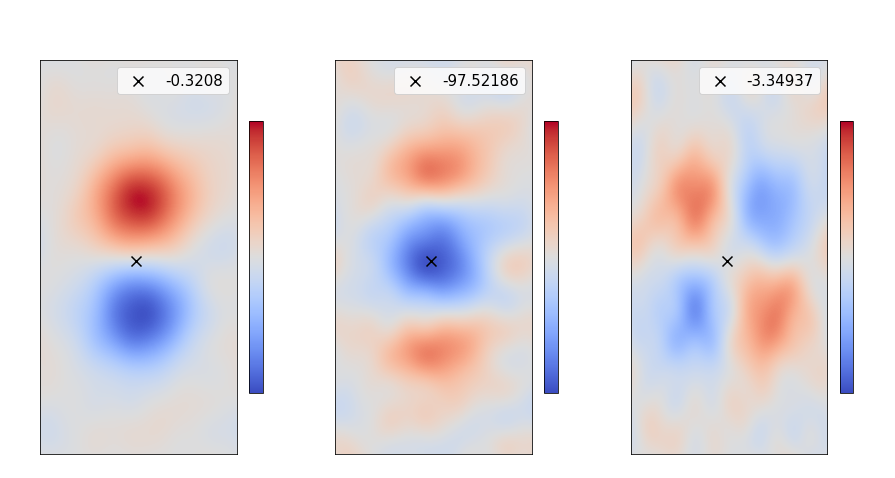

In [17]:
fig, axs = imshow3([true_eta, true_hu, true_hv], eta_vlim=3, huv_vlim=100)
axs[0].scatter(Hx,Hy, marker="x", c="black", label=str(round(obs[0],5)), s=100)
axs[0].legend(labelcolor="black", fontsize=15)
axs[1].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[1],5)), s=100)
axs[1].legend(labelcolor="black", fontsize=15)
axs[2].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[2],5)), s=100)
axs[2].legend(labelcolor="black", fontsize=15)
fig.suptitle("Truth", y=0.85)


### Single-level Ensemble

In [18]:
SL_Ne = 50

In [19]:
SL_ensemble = initSLensemble(SL_Ne, args, data_args, sample_args, 
                    init_model_error_basis_args=init_model_error_basis_args, 
                    sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_time_step=sim_model_error_timestep)


In [20]:
SL_prior = copy.deepcopy(SLdownload(SL_ensemble))

In [21]:
def plot_SL_K(SL_K):
    vlims = [[1, 0.01, 0.01],[10, 1, 1],[10, 1, 1]]

    obs_varN = obs_var.stop-obs_var.start
    obs_varIdx = np.arange(obs_var.start, obs_var.stop)

    fig, axs = plt.subplots(obs_varN, 3, figsize=(10,5*obs_varN))

    for i in range(obs_varN):
        if obs_varN > 1:
            SL_K_field = SL_K[:,:,:,i]
        else:
            SL_K_field = SL_K
        
        for j in range(3):
            if obs_varN == 1:
                ax = axs[j]
            elif obs_varN > 1:
                ax = axs[i,j]
                
            im = ax.imshow(SL_K_field[j,:,:], vmin=-vlims[j][obs_varIdx[i]],vmax=vlims[j][obs_varIdx[i]], cmap="coolwarm")
            ax.scatter(Hx, Hy, marker="x", c="black")
            plt.colorbar(im, ax=ax, shrink=0.5)

    fig.suptitle("Kalman Gain", y=0.9)

Classical Kalman Gain

In [22]:
SL_K = SLEnKF(SL_ensemble, obs, obs_x, obs_y, R, obs_var=slice(1,3))

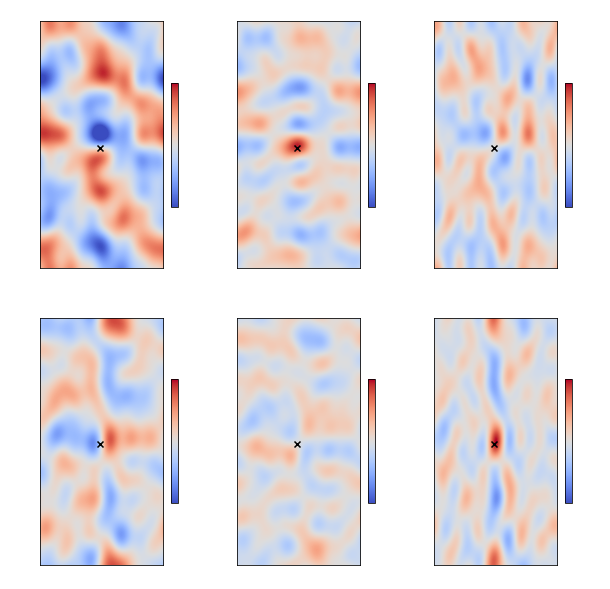

In [23]:
plot_SL_K(SL_K)

Localisation

In [24]:
SLupload(SL_ensemble, SL_prior)

In [26]:
GC = GCweights(SL_ensemble, obs_x, obs_y, r)

In [27]:
SL_K = SLEnKF(SL_ensemble, obs, obs_x, obs_y, R, obs_var=slice(1,3), localisation_weights=GC)

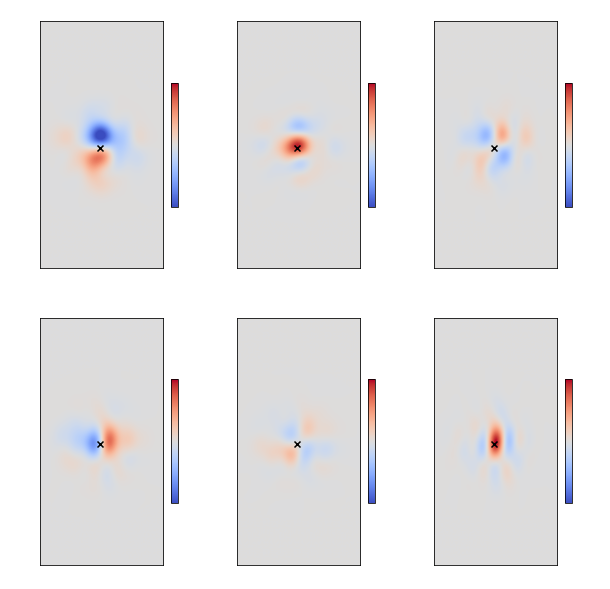

In [28]:
plot_SL_K(SL_K)

Relaxing

In [29]:
SLupload(SL_ensemble, SL_prior)

In [30]:
SL_K = SLEnKF(SL_ensemble, obs, obs_x, obs_y, R, obs_var=slice(1,3), relax_factor=0.5)

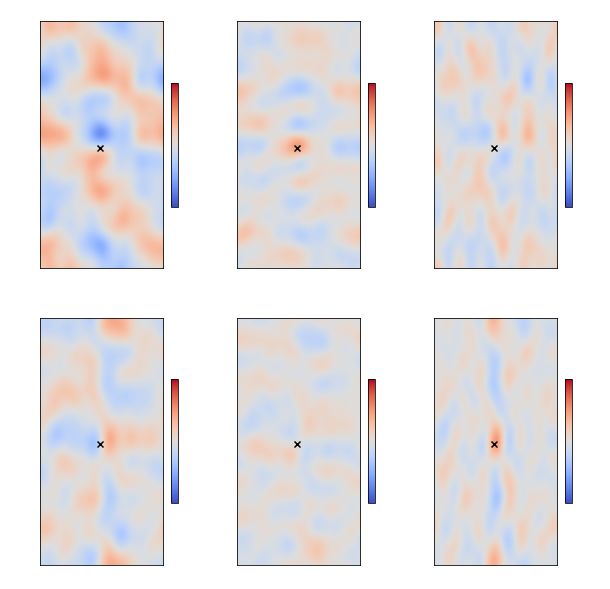

In [31]:
plot_SL_K(SL_K)

In [32]:
SL_K.max()

0.502137078159039